<a href="https://colab.research.google.com/github/Grupo-14-SOA/tp3_hpc/blob/main/Cuaderno_2_grupo14_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 INTRODUCCION

Este ejercicio busca demostrar la eficiencia del cálculo de GPU contra el cálculo secuencial, en cuanto al tiempo de procesamiento o ejecución.
Para comparar se tomará como referencia el cálculo de los puntos de una función y los puntos de su derivada, luego este mismo cálculo se realizará en GPU y se compararán sus tiempos de ejecución para realizar un analisis sobre estos.

La función sobre la que se trabajará es la siguiente.

$ f(x) = sin(x/2)*cos(x*2) $

El cálculo de la derivada de la misma se llevará a cabo por medio del límite de la función cuando delta tiende a cero.

$ f´(x) = \frac{lim}{Δ->0} = \frac{f(x+Δ)-f(x)}{Δ} $


# 2 ARMADO DE AMBIENTE

In [ ]:
#@title ## 2.1 declaracion de variables parametrizables
# Para vizualisar correctamente las metricas debe tomar una muestra de CPU y GPU
# con 50 elementos y con 50.000 elementos
cantidad_de_muestras =   50000#@param {type: "number"}
delta =   0.001#@param {type: "number"}

In [ ]:
#@title ## 2.2 Instala en el cuaderno el módulo CUDA de Python.

!pip install pycuda

# Los declaro como diccionarios para poder agruparlos por la cantidad de muestras de cada muestra
tiempos_secuencial = {}
tiempos_gpu = {}

# 3 Desarollo

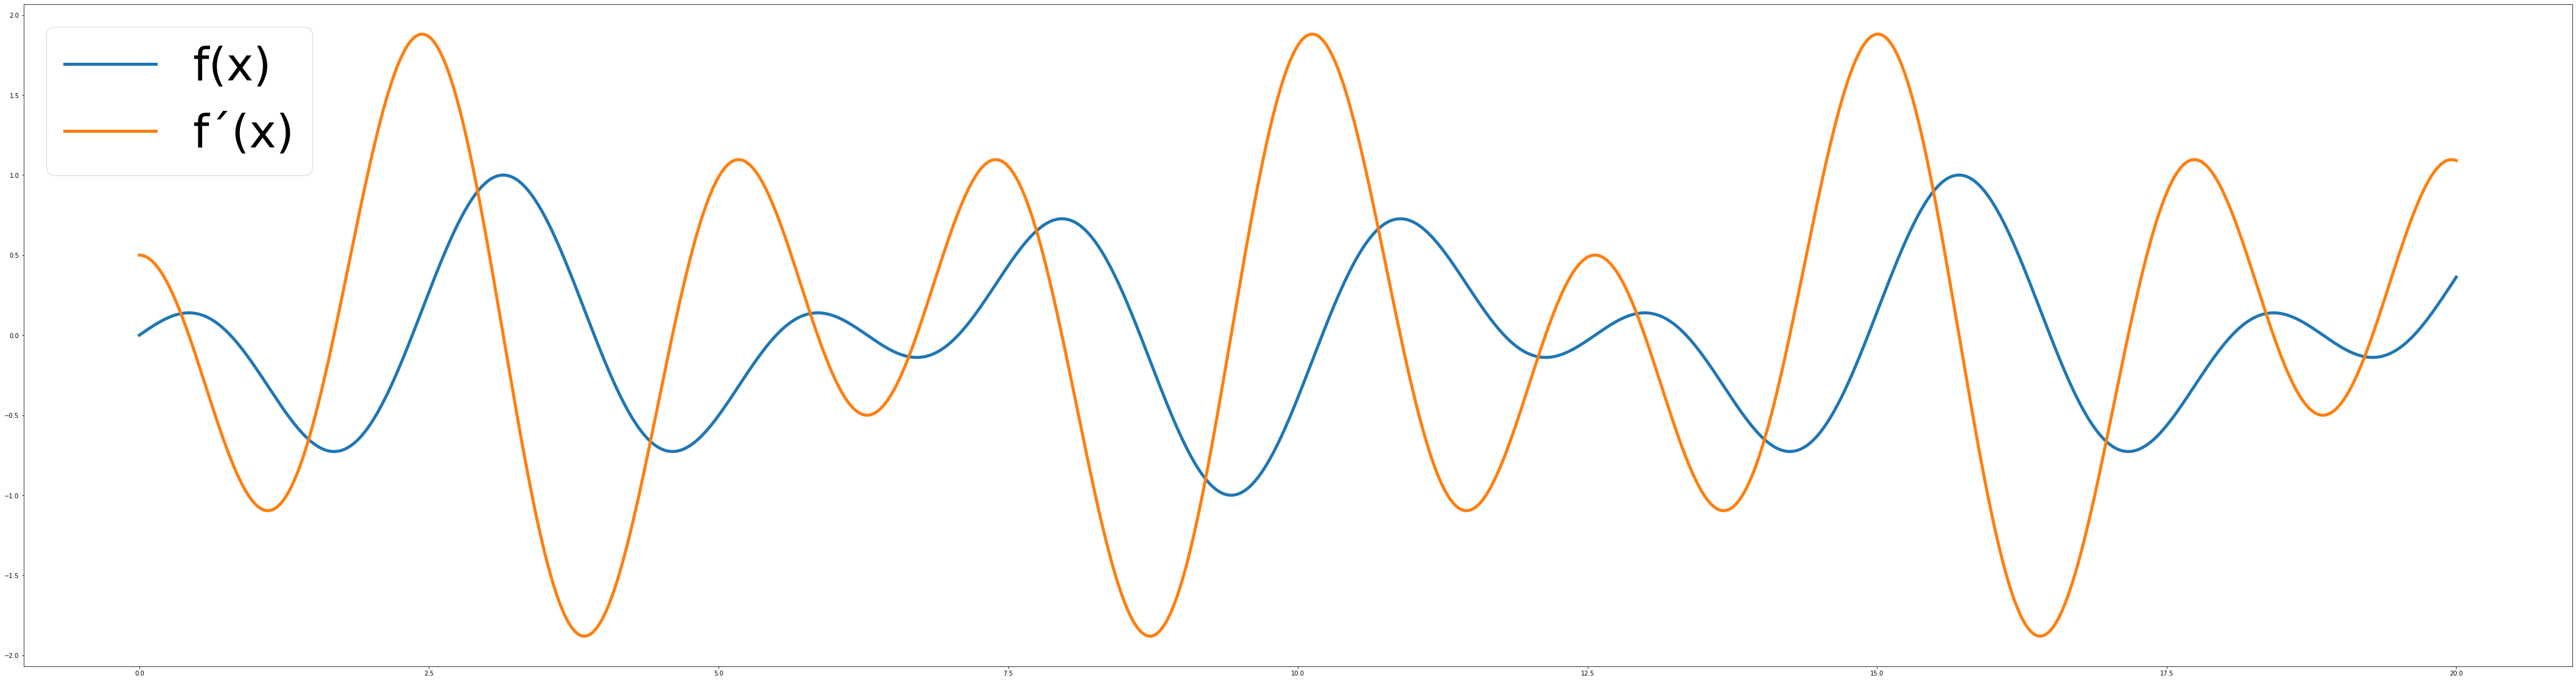

cantidad de muestras  50000
Tiempo ejecucion: 375.76 [ms]
Tiempo Total: 1293.737 [ms]


In [ ]:
# --------------------------------------------
#@title 3.1 Ejecucion CPU
# --------------------------------------------

%matplotlib inline
from datetime import datetime

tiempo_total = datetime.now()

import  matplotlib.pyplot as plt
import numpy
try:
  # Defino el tamaño con el que se mostrara la imagen final
  plt.rcParams["figure.figsize"] = (75,20)

  # --------------------------------------------
  # Definición de función que transforma el tiempo en  milisegundos 
  tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
  # --------------------------------------------

  def fun(x):
    return numpy.sin(x/2)*numpy.cos(x*2)

  def derivada(x):
    return (fun(x+delta)-fun(x))/delta

  tiempo_eje = datetime.now()
  X = [r*20/cantidad_de_muestras for r in range(cantidad_de_muestras)]
  Y = [fun(x) for x in X]
  Z = [derivada(x) for x in X]

  tiempo_eje = datetime.now() - tiempo_eje

  # Guardo los tiempos de ejecucion de esta cantidad de muestras
  if not tiempos_secuencial.get(cantidad_de_muestras):
    tiempos_secuencial[cantidad_de_muestras] = []
  tiempos_secuencial[cantidad_de_muestras].append(tiempo_en_ms(tiempo_eje))

  plt.plot(X,Y, linewidth=5.0, label="f(x)")
  plt.plot(X,Z, linewidth=5.0, label="f´(x)")
  plt.legend(fontsize=75, loc='upper left')
  plt.show()

  tiempo_total = datetime.now() - tiempo_total
  print("cantidad de muestras ", cantidad_de_muestras)
  print( "Tiempo ejecucion:",                   tiempo_en_ms( tiempo_eje ), "[ms]" )
  print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total ), "[ms]" )
except e:
  print("A ocurrido un error durante la ejecucion, por favor verifique haber ejecutado los pasos previos")

Thread x:  32 , Bloque x: 1563


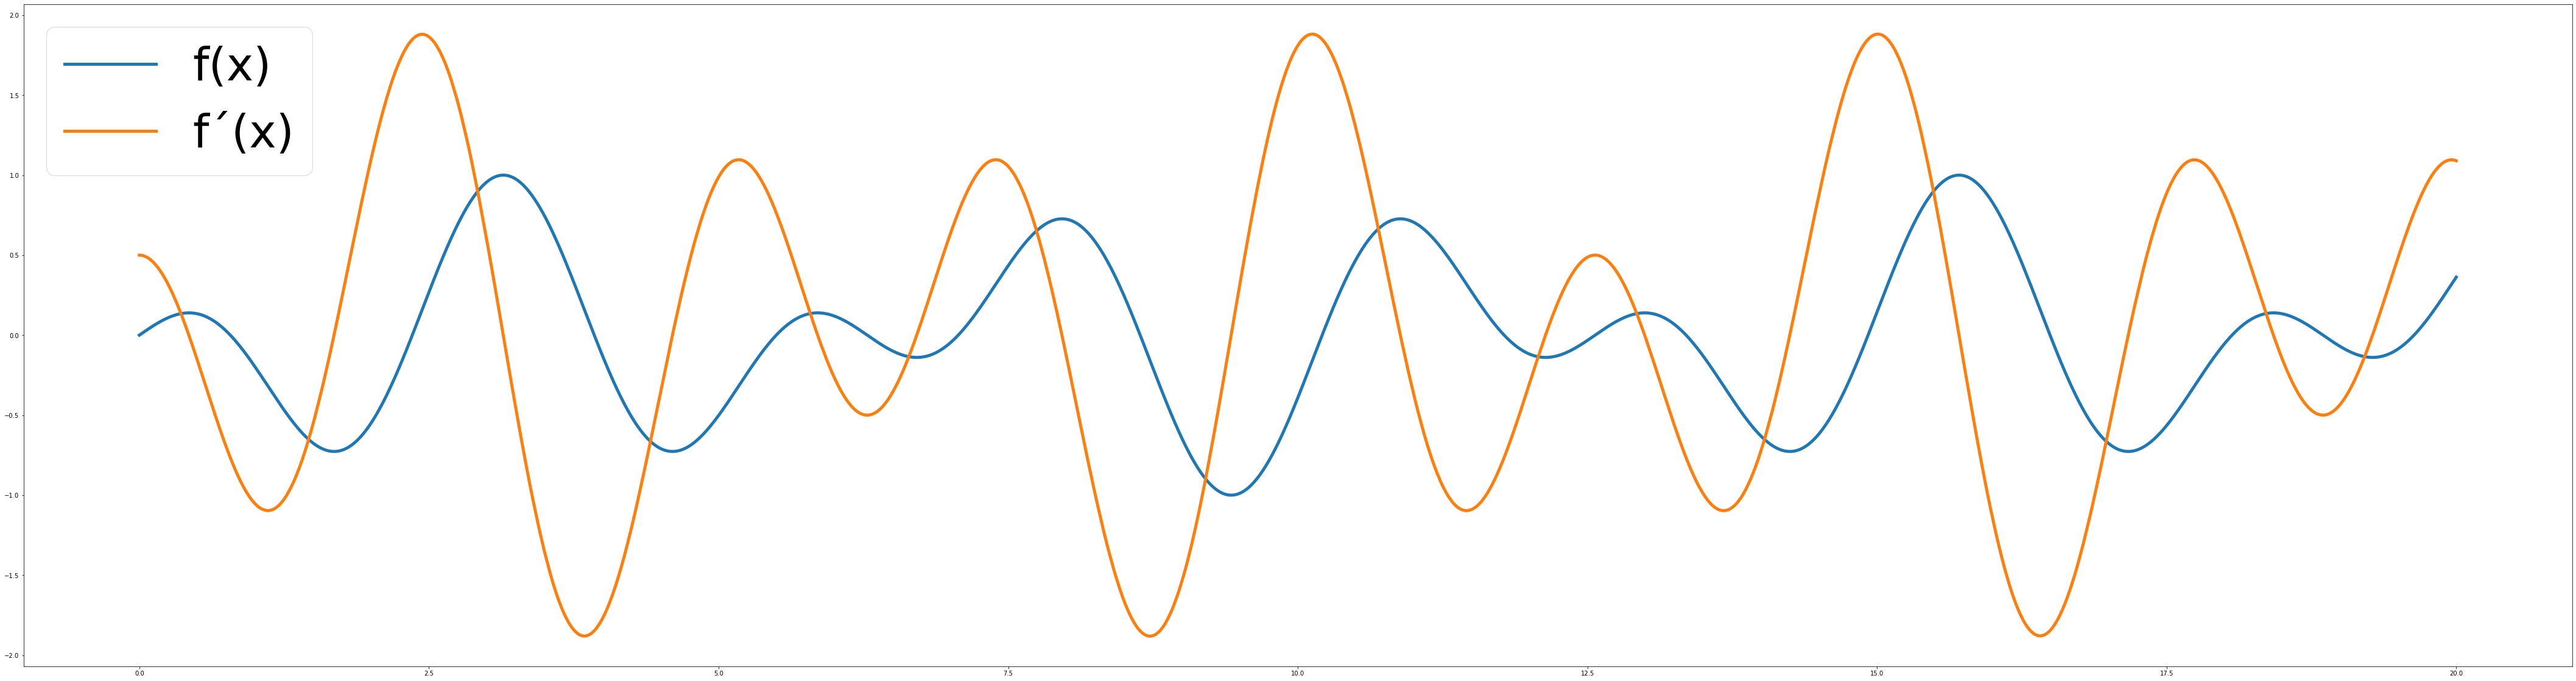

Cantidad de elementos:  50000
Thread x:  32 , Bloque x: 1563
Tiempo TOTAL:  909.003 [ms]
Tiempo GPU:  0.107 [ms]


In [ ]:
# --------------------------------------------
#@title 3.2 Ejecucion GPU
# --------------------------------------------

from datetime import datetime

tiempo_total = datetime.now()
import matplotlib.pyplot as plt
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
try:
  # Defino el tamaño con el que se mostrara la imagen final
  plt.rcParams["figure.figsize"] = (75,20)

  import numpy

  # --------------------------------------------
  # Definición de función que transforma el tiempo en  milisegundos 
  tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0


  # CPU - Defino la memoria de los vectores en cpu.
  # Tomo las cantidad_de_muestras de x ingresadas por el usuario
  x_cpu = numpy.array([r*20/cantidad_de_muestras for r in range(cantidad_de_muestras)])
  x_cpu = x_cpu.astype( numpy.float32() )

  y_cpu = numpy.empty_like( x_cpu )

  #tiempo_ini_cpu = datetime.now()

  r_cpu = numpy.empty_like( x_cpu )

  # CPU - reservo la memoria GPU.
  x_gpu = cuda.mem_alloc( x_cpu.nbytes )
  y_gpu = cuda.mem_alloc( y_cpu.nbytes )
  r_gpu = cuda.mem_alloc( r_cpu.nbytes )

  # GPU - Copio la memoria al GPU.
  cuda.memcpy_htod( x_gpu, x_cpu )
  cuda.memcpy_htod( y_gpu, y_cpu )
  cuda.memcpy_htod( r_gpu, r_cpu )

  # CPU - Defino la función kernel que ejecutará en GPU.
  module = SourceModule("""
  __global__ void kernel_funcion( int n,float h, float *X, float *Y, float *Z )
  {

    int idx = threadIdx.x + blockIdx.x*blockDim.x;
    if( idx < n )
    {
      float x = X[idx];
      float H1 = x+h;
      float H2 = H1+h;
      Y[idx]  = sin(x/2)*cos(x*2);
      Z[idx] = (sin(H1/2)*cos(H1*2)-sin(x/2)*cos(x*2))/h;
    }
  }
  """) 
  # CPU - Genero la función kernel.
  kernel = module.get_function("kernel_funcion")

  # GPU - Ejecuta el kernel.
  # TODO: Falta consultar limites del GPU, para armar las dimensiones correctamente.
  dim_hilo = 32
  dim_bloque = numpy.int( (cantidad_de_muestras+dim_hilo-1) / dim_hilo )
  print( "Thread x: ", dim_hilo, ", Bloque x:", dim_bloque )

  tiempo_gpu = datetime.now()
  #TODO: Ojo, con los tipos de las variables en el kernel.
  kernel( numpy.int32(cantidad_de_muestras),numpy.float32(delta), x_gpu, y_gpu, r_gpu, block=( dim_hilo, 1, 1 ),grid=(dim_bloque, 1,1) )

  tiempo_gpu = datetime.now() - tiempo_gpu
  if not tiempos_gpu.get(cantidad_de_muestras):
    tiempos_gpu[cantidad_de_muestras] = []
  tiempos_gpu[cantidad_de_muestras].append(tiempo_en_ms(tiempo_gpu))

  # GPU - Copio el resultado desde la memoria GPU.
  cuda.memcpy_dtoh( y_cpu, y_gpu )
  cuda.memcpy_dtoh( r_cpu, r_gpu )

  plt.plot(x_cpu,y_cpu, linewidth=5.0, label="f(x)")
  plt.plot(x_cpu,r_cpu, linewidth=5.0, label="f´(x)")
  plt.legend(fontsize=75, loc='upper left')
  plt.show()

  tiempo_total = datetime.now() - tiempo_total

  print( "Cantidad de elementos: ", cantidad_de_muestras )
  print( "Thread x: ", dim_hilo, ", Bloque x:", dim_bloque )
  print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
  print("Tiempo GPU: ", tiempo_en_ms( tiempo_gpu   ), "[ms]" )
except ModuleNotFoundError:
  print("A ocurrido un error al querer importar uno de los modulos, por favor verifique haber ejecutado los pasos previos")
except:
  print("A ocurrido un error durante la ejecucion, por favor verifique haber ejecutado los pasos previos")

#4 Tabla de pasos

## 4.1 pasos para codigo CPU


Procesador |	Funciòn       |	Detalle
-----------|----------------|--------
CPU | @param | Lectura de los parametros, cantidad_de_muestras y delta, ingresados por el usuario
CPU |pip install pycuda | Instala en el cuaderno los driver de CUDA para Python.
CPU |	matplotlib inline |	Macro de Colab para mostrar imagenes.
CPU |	import |	Importa los módulos para funcionar.
CPU |	datetime.now() |	Toma el tiempo actual.
CPU | plt.rcParams["figure.figsize"] = (75,20) | Se define el tamaño de la imagen que se mostrara con la funcion y su derivada
CPU | plt.plot(X,Y) | preparo para mostrar la funcion
CPU | plt.plot(X,Z) | prepao para mostrar la derivada de la funcion
CPU | plt.show() | Muestro la funcion y su derivada
CPU | print() | Muestra los tiempos de ejecucion



## 4.2 Pasos para codigo GPU

Procesador |	Funciòn       |	Detalle
-----------|----------------|--------
CPU | @param | Lectura de los parametros, cantidad_de_muestras y delta, ingresados por el usuario
CPU |pip install pycuda | Instala en el cuaderno los driver de CUDA para Python.
CPU |	matplotlib inline |	Macro de Colab para mostrar imagenes.
CPU |	import |	Importa los módulos para funcionar.
CPU |	datetime.now() |	Toma el tiempo actual.
CPU | plt.rcParams["figure.figsize"] = (75,20) | Se define el tamaño de la imagen que se mostrara con la funcion y su derivada
**GPU**	| cuda.mem_alloc() |	Reserva la memoria para los venctores de pos puntos en X, los puntos de f(x) y los puntos de f´(x) en GPU.
**GPU**	| cuda.memcpy_htod() |	Copio los valores en crudo de los vectores al GPU.
CPU	| SourceModule() |	Posee el còdigo del kernel.
CPU	| module.get_function() |	convierte el texto del kernel en funcion de Python.
CPU	| dim_bloque |	Calcula las dimensiones para la ejecuciòn de 1D.
**GPU** |	kernel() |	Ejecuta el kernel en GPU, enviando los parametros.
CPU	| cuda.memcpy_dtoh() |	Copia desde la memoria GPU al CPU.
CPU | plt.plot(X,Y) | preparo para mostrar la funcion
CPU | plt.plot(X,Z) | prepao para mostrar la derivada de la funcion
CPU | plt.show() | Muestro la funcion y su derivada 
CPU | print() | Muestra los tiempos de ejecucion


# 5 Metricas

En esta sección vamos a analizar, mediante gráficos y resultados, las diferencias entre la implementación secuencial y concurrente. Además, vamos a incluir gráficos comparando los tiempos de respuesta con la cantidad de muestras tomadas para graficar las funciones.

A continuacion se graficaran los tiempos de ejecucion en GPU y CPU segun la cantidad de muestras de cada tiempo


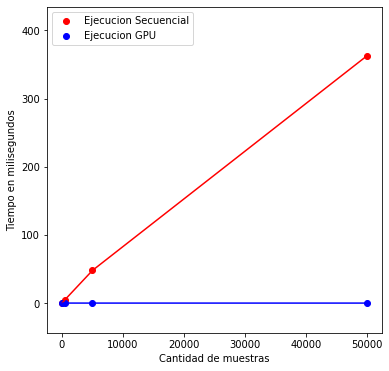

tiempo CPU de 50 muestras:  0.509
tiempo GPU de 50 muestras:  0.101
Relacion de tiempo de 50 muestras CPU/GPU:  5.03960396039604
tiempo CPU de 50.000 muestras:  362.23
tiempo GPU de 50.000 muestras:  0.086
Relacion de tiempo de 50.000 muestras CPU/GPU:  4211.976744186047

Con la relacion de 50 muestras y 50000 muestras entre procesamiento CPU y GPU se puede obtener 
una funcion para determinar cuanto va a crecer la diferencia en tiempo de CPU y GPU.
Relacion de tiempo entre la relacion de 50 muestras y 50.000 muestras:  0.0842229657702833
Funcion que determina la diferencia que habra entre el timempo CPU y el tiempo GPU
f(x) = 0.0842229657702833*cantidad_de_muestras


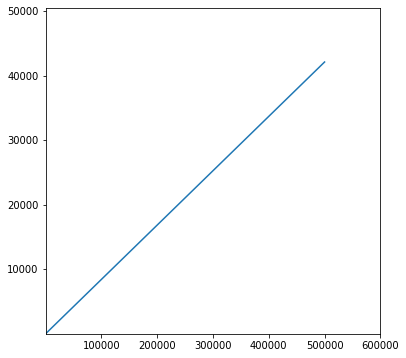

Con esta funcion se pueda calcular cuanto sera la diferencia en los tiempos de ejecucion para el procesamiento de CPU y GPU.
Por ejemplo, la diferencia que habria entre el calculo de GPU y CPU, trabajando con 5.000.000.000 elementos seria de: 421114828.8514165 veces
Por lo que si sabemos que el tiempo de ejecucion de GPU ronda al rededor de 0,14 milisegundos podemos calcular que el tiempo de ejecucion en CPU 
de 5.000.000.000 de elementos seria de 58956076.03919832 milisegundos o 58956.07603919831 segundos o 982.6012673199718 minutos o 16.376687788666196 horas


In [ ]:
#@title 5.1 Análisis con código
try:
  plt.rcParams["figure.figsize"] = (6, 6)

  plt.xlabel("Cantidad de muestras")
  plt.ylabel("Tiempo en milisegundos")
  secuencial_x = []
  secuencial_y = []
  gpu_x = []
  gpu_y = []
  max_y = 4
  for key in tiempos_secuencial.keys():
    secuencial_x.append(float(key))
    # Calculo el primedio de los tiempos para esa cantidad de muestras
    tiempo = ((sum(tiempos_secuencial[key]))/len(tiempos_secuencial[key]) ) if tiempos_secuencial[key] else 0
    secuencial_y.append( tiempo )
    if tiempo>max_y:
      max_y=tiempo

  for key in tiempos_gpu.keys():
    gpu_x.append(float(key))
    # Calculo el primedio de los tiempos para esa cantidad de muestras
    tiempo = ((sum(tiempos_gpu[key]))/len(tiempos_gpu[key]) ) if tiempos_gpu[key] else 0
    gpu_y.append( tiempo )
    if tiempo>max_y:
      max_y=tiempo

  print("A continuacion se graficaran los tiempos de ejecucion en GPU y CPU segun la cantidad de muestras de cada tiempo")
  # Agrando un poco el grafico en altura, para poder mostrar la anotacion de que significa cada color
  plt.ylim(-max_y*1.2/10, max_y*1.2)
  plt.scatter(secuencial_x,secuencial_y, color='r', label="Ejecucion Secuencial")
  plt.scatter(gpu_x,gpu_y, color='b', label="Ejecucion GPU")
  plt.plot(secuencial_x,secuencial_y, color='r')
  plt.plot(gpu_x,gpu_y, color='b')
  plt.legend(loc='upper left')
  plt.show()
except:
  print("A ocurrido un error durante la ejecucion, por favor verifique haber ejecutado los pasos previos")

try:
  elementos_50_sec = sum(tiempos_secuencial[50])/len(tiempos_secuencial[50])
  elementos_50_gpu = sum(tiempos_gpu[50])/len(tiempos_gpu[50])
  print("tiempo CPU de 50 muestras: ",elementos_50_sec)
  print("tiempo GPU de 50 muestras: ",elementos_50_gpu)
  print("Relacion de tiempo de 50 muestras CPU/GPU: ", elementos_50_sec/elementos_50_gpu)

  elementos_50k_sec = sum(tiempos_secuencial[50000])/len(tiempos_secuencial[50000])
  elementos_50k_gpu = sum(tiempos_gpu[50000])/len(tiempos_gpu[50000])
  print("tiempo CPU de 50.000 muestras: ",elementos_50k_sec)
  print("tiempo GPU de 50.000 muestras: ",elementos_50k_gpu)
  print("Relacion de tiempo de 50.000 muestras CPU/GPU: ", elementos_50k_sec/elementos_50k_gpu)

  # Se calcula la pendiente que tendria la funcion con la que podriamos determinar 
  #el crecimiento de la diferencia de los tiempos de ejecucion
  pendiente = ((elementos_50k_sec/elementos_50k_gpu) - (elementos_50_sec/elementos_50_gpu ))/(50000-50)
  print("\nCon la relacion de 50 muestras y 50000 muestras entre procesamiento CPU y GPU se puede obtener \nuna funcion para determinar cuanto va a crecer la diferencia en tiempo de CPU y GPU.")
  print("Relacion de tiempo entre la relacion de 50 muestras y 50.000 muestras: ", pendiente )

  # Esta funcion busca determinar cuanto seria la diferencia del tiempo de ejecucion de CPU contra GPU
  def funcion_de_diferencia(x):
    return pendiente*x
  print("Funcion que determina la diferencia que habra entre el timempo CPU y el tiempo GPU")
  print("f(x) = {}*cantidad_de_muestras".format(pendiente))
  X = [5,50,500,5000,50000,500000]
  Y = [funcion_de_diferencia(x) for x in X]
  plt.figure()
  plt.xlim(min(X)*1.2, max(X)*1.2)
  plt.ylim(min(Y)*1.2, max(Y)*1.2)
  plt.plot(X,Y)
  plt.show()
  print("Con esta funcion se pueda calcular cuanto sera la diferencia en los tiempos de ejecucion para el procesamiento de CPU y GPU.")
  print("Por ejemplo, la diferencia que habria entre el calculo de GPU y CPU, trabajando con 5.000.000.000 elementos seria de: {} veces".format(funcion_de_diferencia(5000000000)))
  print("Por lo que si sabemos que el tiempo de ejecucion de GPU ronda al rededor de 0,14 milisegundos podemos calcular que el tiempo de ejecucion en CPU \nde 5.000.000.000 de elementos seria de {} milisegundos o {} segundos o {} minutos o {} horas".format( 0.14*funcion_de_diferencia(5000000000),0.14*funcion_de_diferencia(5000000000)/1000,0.14*funcion_de_diferencia(5000000000)/1000/60,0.14*funcion_de_diferencia(5000000000)/1000/60/60))
except:
  print("No se tomo una muestra de 50 elementos o de 50.000 elementos")


# 6 Conclusion

<p align="justify ">
Para finalizar, del analisis que se aplico en este ejercicio sobre las metricas de los tiempos de ejecucion, se puede observar como a baja cantidad de muestras el tiempo de procesamiento secuencial de la CPU es muy similar al tiempo de procesamiento paralelo de la GPU, pero a medida que se va incrementando la cantidad de muestras esta diferencia se va incrementando cada ves mas. De esto tambien se pudo determinar una funcion que nos puede indicar como sera la diferecia proporcional entre el tiempo de ejecucion de CPU y GPU para una $x$ cantidad de muestras a procesar.

Por otro lado analizando los graficos de los tiempos de ejecucion de CPU y GPU se pudo observar que el tiempo de ejecucion de GPU permanece practicamente constante mientras el tiempo de procesamiento de CPU representa una funcion creciente.

</p>

# 7 Bibliografia


[1] https://claudiovz.github.io/scipy-lecture-notes-ES/intro/matplotlib/matplotlib.html#figuras

[2] https://www.ugr.es/~camilo/calculo-ii-grado-en-matemat/apuntes/tema-5.pdf

[3] http://www.fba.unlp.edu.ar/matematica/pdfs/5-rectas.pdf